# Documentation

## CpG-Gene Enrichment Analysis Pipeline
## Overview
Analyze the relationship between genomic *peaks*, *CpG islands*, and gene *transcription start sites* (TSS) in different cell types and conditions. 

>Identify genes with CpG-overlapping peaks near their TSS regions and perform comprehensive comparative analysis.

Purposes:
1. Identify genomic peaks that overlap with CpG islands
2. Analyze the relationship between CpG-associated peaks and gene TSS regions
3. Compare differences in CpG-gene associations between:
   - Different cell types (NSC and Neurons)
   - Different conditions (Exogenous and Endogenous)

Features:
- Filters for standard chromosomes (chr1-22, X, Y)
- Extends CpG islands and TSS regions by customizable distances
- Calculates coverage statistics for peak-CpG overlaps
- Identifies genes with CpG-overlapping peaks near their TSS
- Generates comparative analysis between different conditions

Input:
- Peak files in BED format (`results/consensus_peaks/{cell_type}_{condition}_consensus.bed`)
- CpG islands file in BED format (`DATA/cpg_islands.bed`)
- Gene annotation file in GTF format (`DATA/gencode.vM10.annotation.gtf`)
- Genome size file (`DATA/genome.size`)

Key Parameters:
- `extend_cpg`: Base pairs to extend CpG islands (default: 300bp)
- `extend_tss`: Base pairs to extend TSS regions (default: 2000bp)
- `coverage_threshold`: Minimum percentage overlap required (adjustable, examples use 20% and 80%)

Output Files:
The pipeline generates several output files across multiple directories:

### Main Analysis Output (`results/cpg_gene_analysis/`)
- `{cell_type}_{condition}_cpg_genes.tsv`: Detailed gene-level statistics
- `{cell_type}_common_genes.txt`: Genes common between conditions
- `comparison_summary.txt`: Overall comparison statistics

### Visualization Output (`results/visualizations/`)
- `peak_distribution.png`: Violin plots of peaks per gene
- `distance_distribution.png`: KDE plots of TSS distances
- `{cell_type}_venn.png`: Venn diagrams of condition overlaps
- `{cell_type}_{condition}_top_genes_heatmap.png`: Heatmaps of top genes
- `total_genes_summary.png`: Bar plots of total genes
- `peak_size_distribution.png`: Box plots of peak sizes

### Comprehensive Analysis Output (`results/comprehensive_analysis/`)
- `endo_cpg_coverage_comparison.png`: Comparison of Endo coverage between cell types
- `cpg_target_overlap.png`: Four-way Venn diagram of all conditions
- `endo_coverage_stats.txt`: Statistical analysis of coverage patterns
- `cpg_overlap_stats.txt`: Detailed overlap statistics
- `{cell_type}_exo_enriched_genes.tsv`: Exo vs Endo enrichment analysis
- `common_enriched_genes.txt`: Genes enriched in both cell types

## Main Functions

### Data Processing Functions
1. **get_peaks_with_cpg()**
   - *Identifies peaks overlapping with CpG islands*
   - Calculates coverage statistics
   - Filters based on coverage threshold

2. **get_genes_with_cpg_enrichment()**
   - *Maps CpG-overlapping peaks to nearby genes*
   - Calculates various metrics including:
     - Number of peaks per gene
     - Total coverage
     - Average peak size
     - Minimum distance to TSS

3. **extract_tss_regions()**
   - Extracts TSS locations from GTF file
   - Filters for protein-coding genes
   - Handles both forward and reverse strands

### Analysis Functions
4. **compare_endo_cpg_coverage()**
   - *Compares CpG coverage between NPCs and Neurons*
   - Performs statistical testing
   - Generates coverage distribution plots

5. **analyze_common_cpg_targets()**
   - *Identifies targets common across conditions*
   - Creates four-way Venn diagrams
   - Calculates pairwise overlaps

6. **analyze_exo_vs_endo_enrichment()**
   - Calculates enrichment ratios
   - Identifies significantly enriched genes
   - Finds common enriched genes across cell types

### Visualization Functions
7. **plot_peak_distribution()**
   - Creates violin plots of peak distributions
   - Compares across all conditions

8. **plot_distance_distribution()**
   - Generates KDE plots of TSS distances
   - Shows distribution patterns across conditions

9. **create_venn_diagrams()**
   - Visualizes overlap between conditions
   - Separate diagrams for each cell type

10. **plot_top_genes_heatmap()**
    - Creates heatmaps of top genes
    - Shows normalized coverage scores

### Utility Functions
11. **load_and_process_data()**
    - Loads analysis results
    - Calculates additional metrics
    - Prepares data for visualization

12. **create_comparison_summary()**
    - Generates comparative analysis
    - Identifies condition-specific genes
    - Calculates overlap statistics

## Usage
The pipeline can be run with different coverage thresholds:
```python
# For 20% coverage threshold
get_genes_with_cpg_enrichment(..., coverage_threshold=20)

# For 80% coverage threshold
get_genes_with_cpg_enrichment(..., coverage_threshold=80)
```

Visualizations can be generated using:
```python
generate_all_visualizations(results_dir, visualization_dir)
generate_comprehensive_analysis(results_dir, analysis_dir)
```

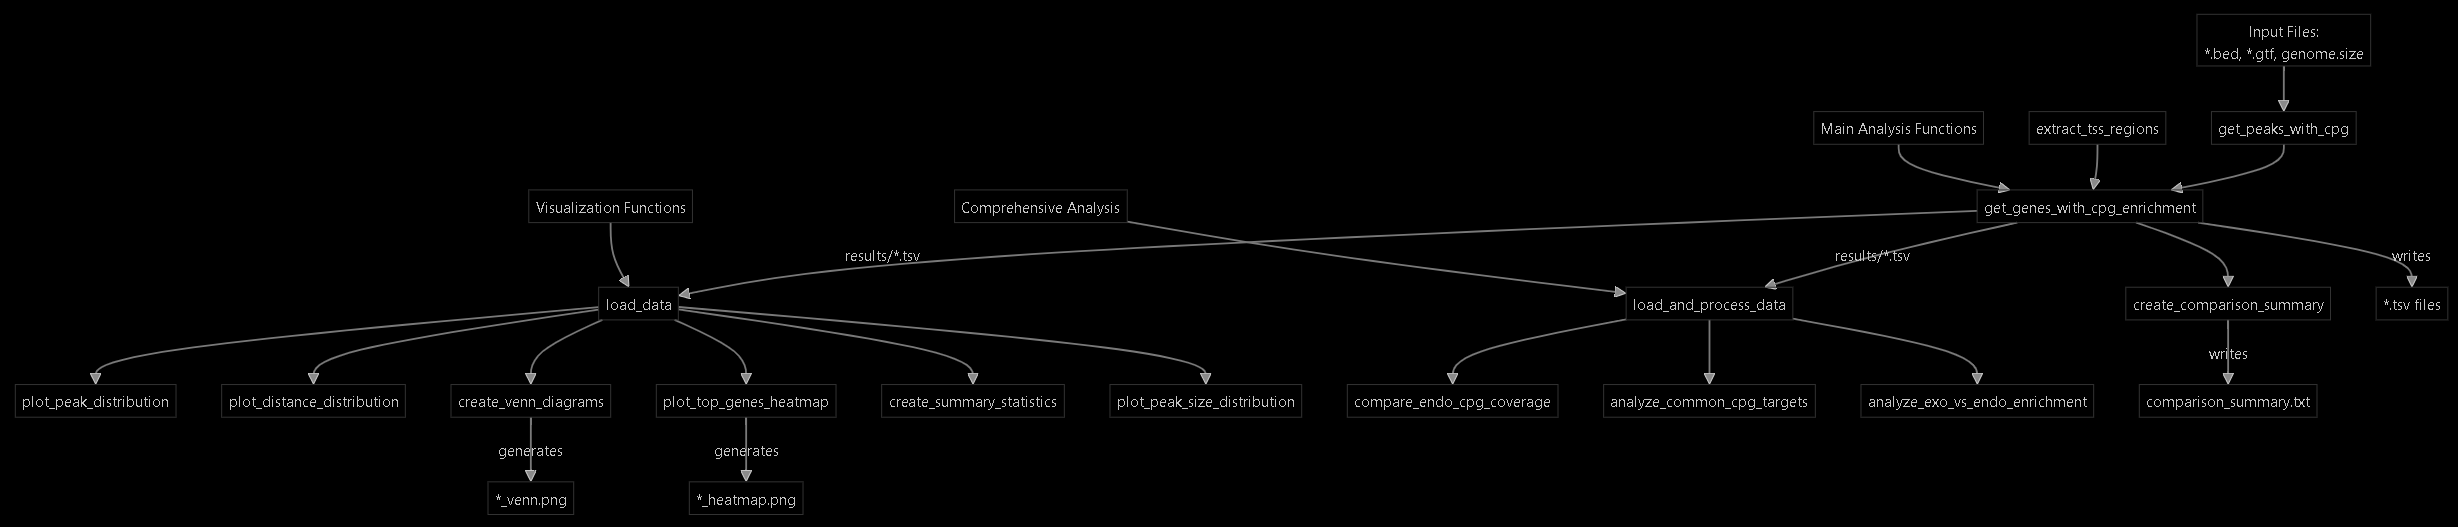

# Environment

In [40]:
# Standard library imports
import os
import subprocess
from collections import defaultdict
from pathlib import Path

# Third party imports
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import glob
from IPython.display import Image, display
from venn import venn

wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_CUTandTAG/custom_pipeline'
os.chdir(wd_dir)

current_dir = os.getcwd()

import importlib
import functions_CpG_enriched_genes
importlib.reload(functions_CpG_enriched_genes)
from functions_CpG_enriched_genes import *


# Run analysis

## 20% coverage threshold

In [167]:
# Setup paths
cpg_file = "DATA/cpg_islands.bed"
gtf_file = "DATA/gencode.vM10.annotation.gtf"
output_dir = "results/cpg_gene_analysis"
os.makedirs(output_dir, exist_ok=True)

results = {}

for cell_type in ['NSC', 'Neuron']:
    results[cell_type] = {}
    for condition in ['Exo', 'Endo']:
        peak_file = f"results/consensus_peaks/{cell_type}_{condition}_consensus.bed"
        
        result = get_genes_with_cpg_enrichment(
            peak_file=peak_file,
            cpg_file=cpg_file,
            gtf_file=gtf_file,
            output_dir=output_dir,
            cell_type=cell_type,
            condition=condition,
            extend_cpg=0,
            extend_tss=2000,
            coverage_threshold=20
        )
        
        if result is not None:
            results[cell_type][condition] = result
        else:
            print(f"Skipping comparison for {cell_type} {condition} due to processing error")
            results[cell_type][condition] = {'genes': pd.DataFrame(), 'total_peaks': 0}


Analyzing NSC Exo peaks

Processing results/consensus_peaks/NSC_Exo_consensus.bed
Peaks after chromosome filtering: 6993

Peaks with any CpG overlap: 2231
Peaks meeting 20% coverage threshold: 2074
Coverage range: 20.15% - 100.00%
Mean coverage of qualified peaks: 66.03%
Found 2121 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Exo_cpg_genes.tsv

Analyzing NSC Endo peaks

Processing results/consensus_peaks/NSC_Endo_consensus.bed
Peaks after chromosome filtering: 12844

Peaks with any CpG overlap: 4828
Peaks meeting 20% coverage threshold: 4572
Coverage range: 20.06% - 100.00%
Mean coverage of qualified peaks: 64.79%
Found 4596 genes with CpG-overlapping peaks
Results saved to: results/cpg_gene_analysis/NSC_Endo_cpg_genes.tsv

Analyzing Neuron Exo peaks

Processing results/consensus_peaks/Neuron_Exo_consensus.bed
Peaks after chromosome filtering: 43740

Peaks with any CpG overlap: 9488
Peaks meeting 20% coverage threshold: 8239
Coverage range: 20.00% -

In [168]:
create_comparison_summary(results, output_dir)

# Visualization 1

In [169]:
results_dir = "results/cpg_gene_analysis"
data = load_and_process_data(results_dir)

In [170]:
# visualization_dir = "results/visualizations"
# generate_all_visualizations(results_dir)

In [171]:
# plot_peak_distribution(data)

In [172]:
# plot_distance_distribution(data)

In [228]:
import importlib
import functions_CpG_enriched_genes
importlib.reload(functions_CpG_enriched_genes)
from functions_CpG_enriched_genes import *

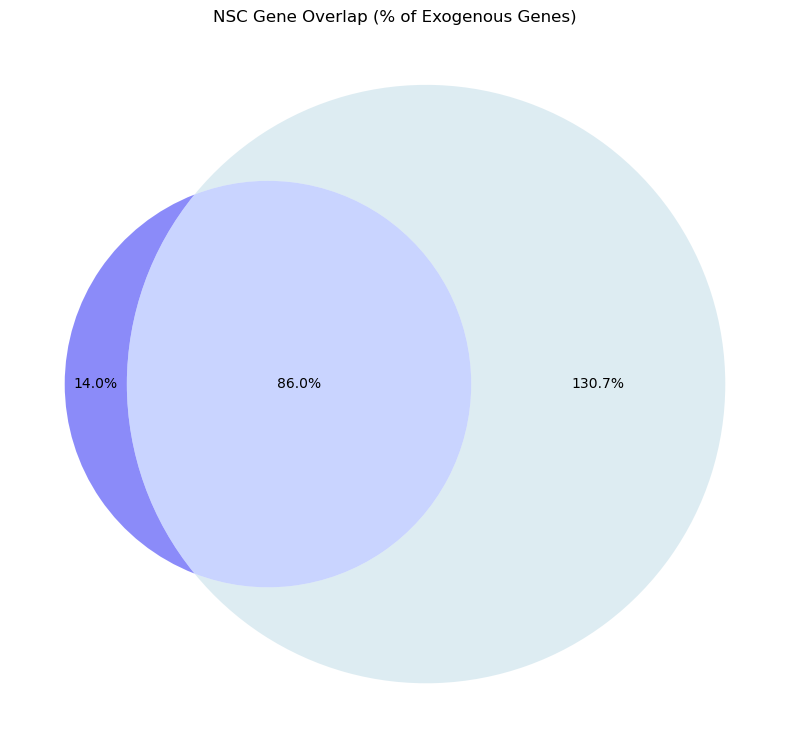

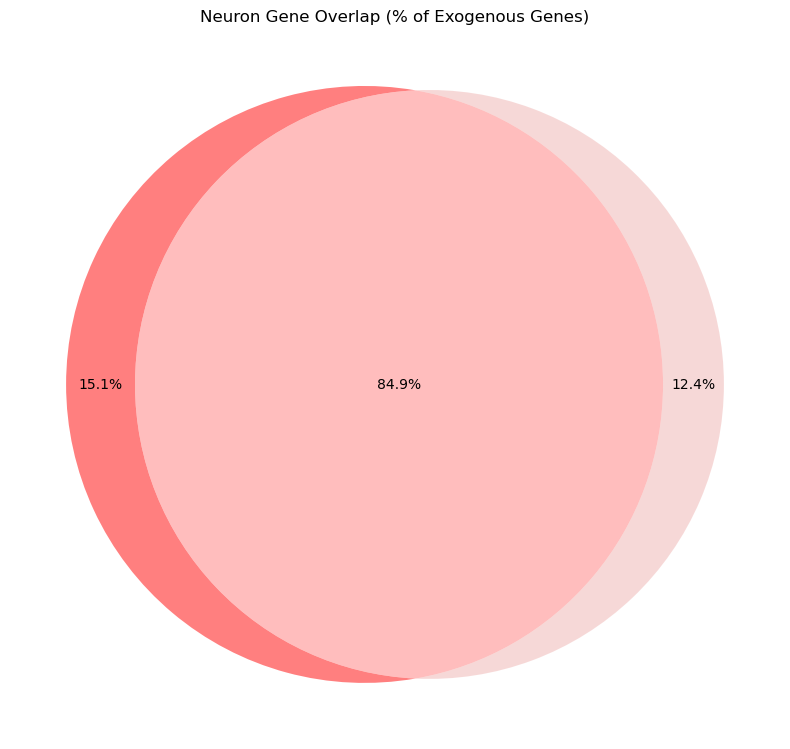

In [226]:
create_venn_diagrams_percentages(data)

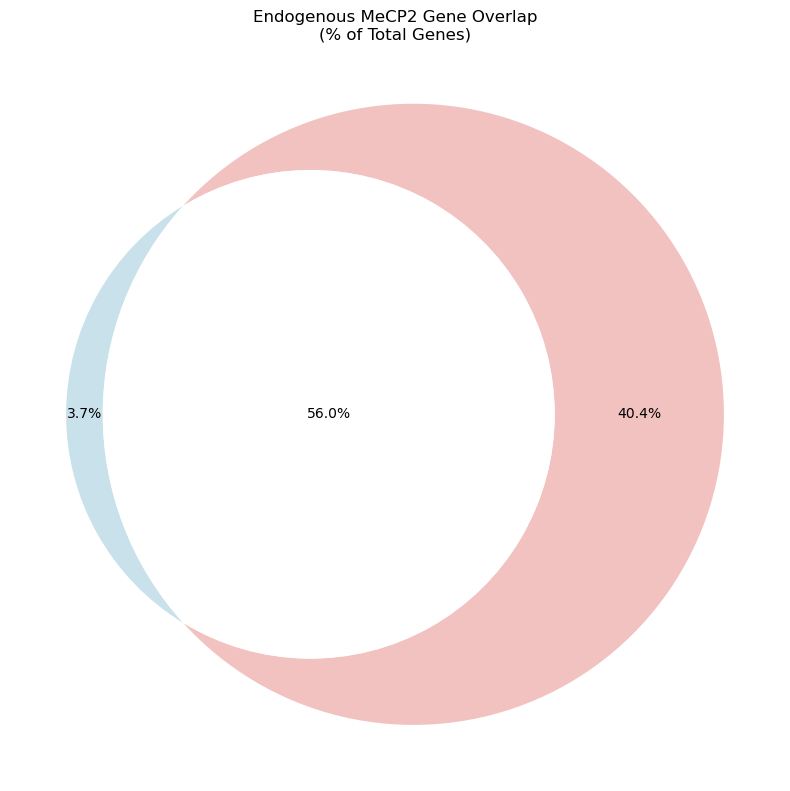


Endogenous MeCP2 Binding Statistics:
NSC-specific genes: 282 (3.7% of total genes)
Neuron-specific genes: 3113 (40.4% of total genes)
Common genes: 4314 (56.0% of total genes)


In [231]:
import importlib
import functions_CpG_enriched_genes
importlib.reload(functions_CpG_enriched_genes)
from functions_CpG_enriched_genes import *

create_venn_diagrams_endo_comparison(data)

In [174]:
# plot_top_genes_heatmap(data)


,Cell Type,Condition,Total Genes,Mean Peaks per Gene,Median Peaks per Gene,Mean Distance to TSS,Median Distance to TSS,Total Peak Coverage,Mean Peak Coverage
0,NSC,Exo,2121,1.007544,1.0,233.841584,133.0,1300477,613.143329
1,NSC,Endo,4596,1.018277,1.0,225.219539,122.0,2824402,614.534813
2,Neuron,Exo,7631,1.045210,1.0,195.780894,92.0,3374536,442.214127
3,Neuron,Endo,7427,1.036085,1.0,210.168709,112.0,4533483,610.405682


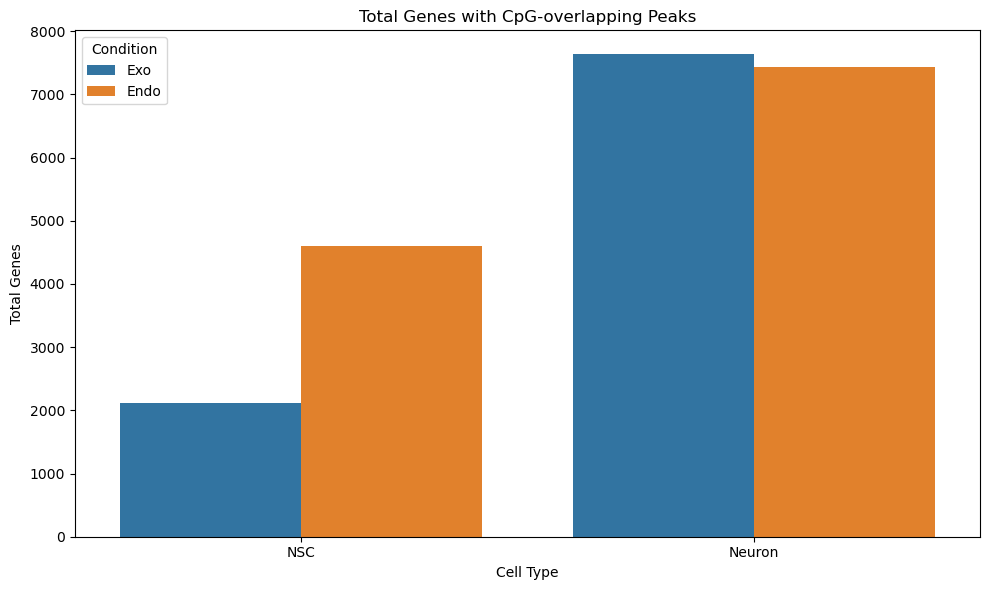

In [175]:
create_summary_statistics(data)


In [176]:
# plot_peak_size_distribution(data)

In [177]:
# print("Displaying generated visualizations:")
# for img_path in glob.glob(f"{visualization_dir}/*.png"):
#     print(f"\n{os.path.basename(img_path)}:")
#     display(Image(filename=img_path, width=500))


<Figure size 1000x1000 with 0 Axes>

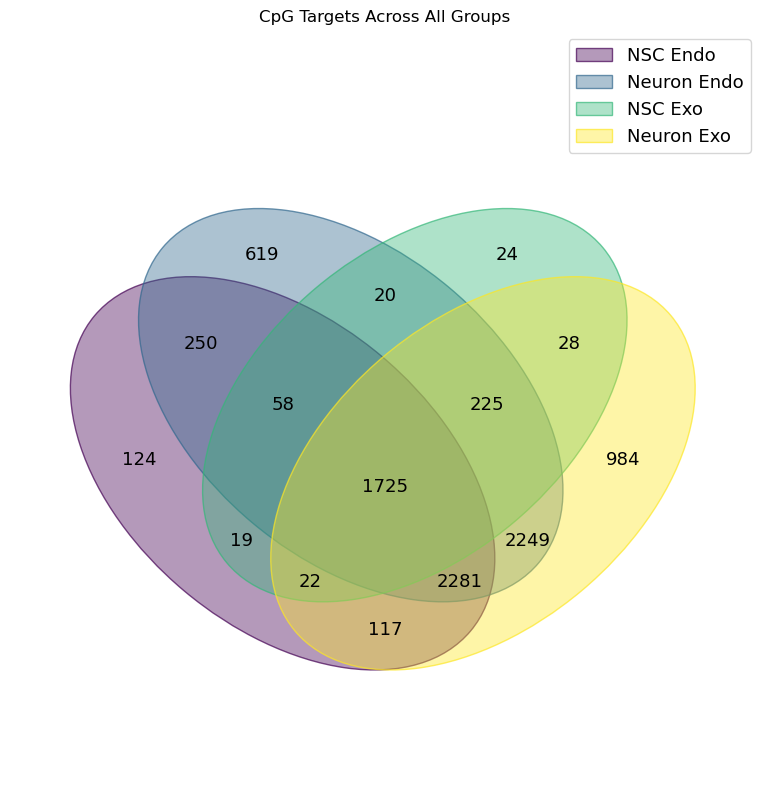

CpG Target Statistics:
--------------------------------------------------
NSC Endo targets: 4596
Neuron Endo targets: 7427
NSC Exo targets: 2121
Neuron Exo targets: 7631
--------------------------------------------------
Total unique targets: 8745
Common targets (all groups): 1725 (19.73%)

Pairwise Overlaps:
--------------------------------------------------
NSC Endo vs Neuron Endo: 4314 (55.96%)
NSC Endo vs NSC Exo: 1824 (37.28%)
NSC Endo vs Neuron Exo: 4145 (51.29%)
Neuron Endo vs NSC Exo: 2028 (26.97%)
Neuron Endo vs Neuron Exo: 6480 (75.54%)
NSC Exo vs Neuron Exo: 2000 (25.80%)

Group-Specific Targets:
--------------------------------------------------
NSC Endo-specific: 124
Neuron Endo-specific: 619
NSC Exo-specific: 24
Neuron Exo-specific: 984

NSC Enrichment Summary:
Total genes analyzed: 1824
Enriched genes: 109
Mean enrichment ratio: 0.96
Median enrichment ratio: 0.96

Neuron Enrichment Summary:
Total genes analyzed: 6480
Enriched genes: 188
Mean enrichment ratio: 0.84
Median

In [178]:
generate_comprehensive_analysis(results_dir)

## NSCs vs Neurons

In [179]:
# compare_endo_cpg_coverage(data)

In [204]:
import importlib
import functions_CpG_enriched_genes
importlib.reload(functions_CpG_enriched_genes)
from functions_CpG_enriched_genes import *

Number of common genes: 4314


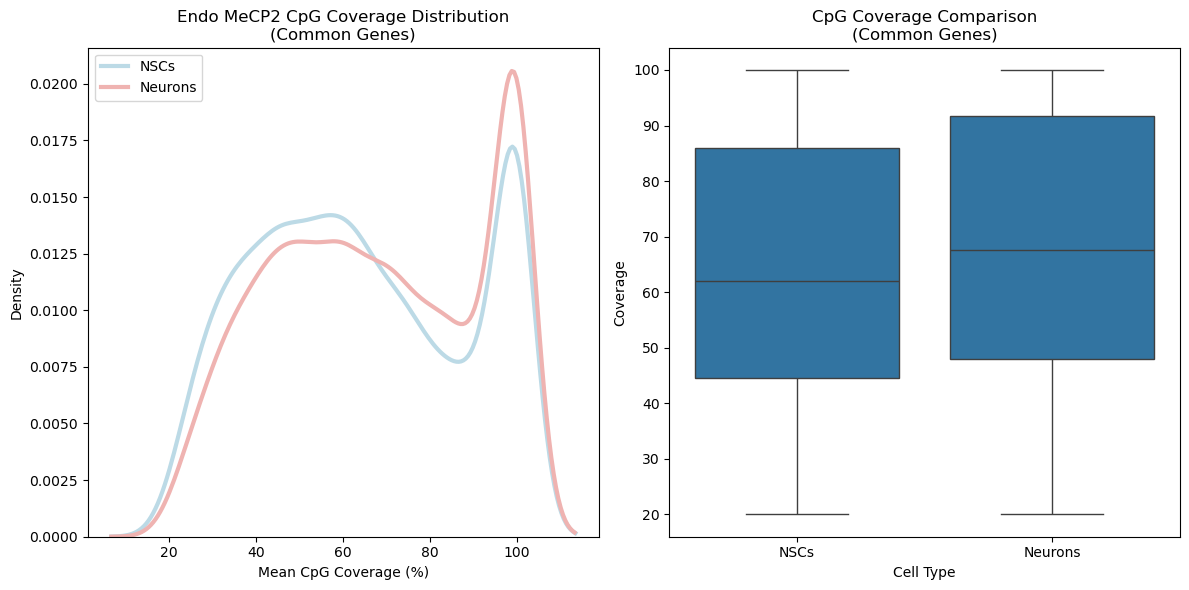


Mann-Whitney U test results (Common Genes):
Statistic: 8501235.0
p-value: 3.251370379163172e-12

Summary Statistics (Common Genes):
NSCs mean coverage: 64.43%
Neurons mean coverage: 68.07%
NSCs median coverage: 62.05%
Neurons median coverage: 67.65%

Number of common genes (Exo): 2000


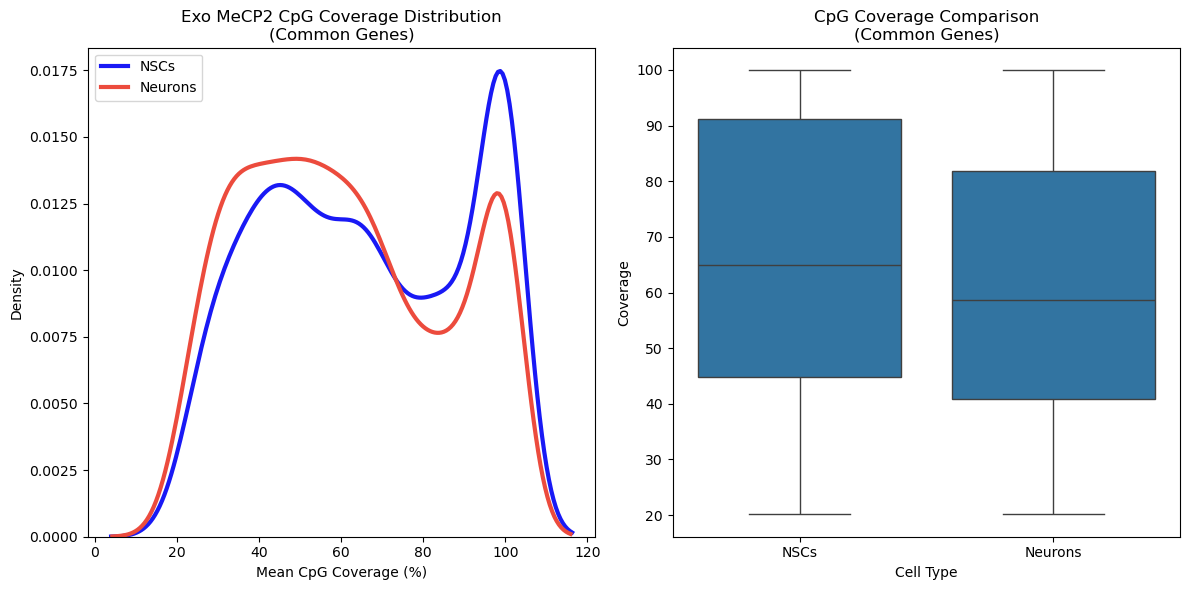


Exo MeCP2 Mann-Whitney U test results (Common Genes):
Statistic: 2234037.5
p-value: 1.3665788433722152e-10

Summary Statistics (Common Genes):
NSCs mean coverage: 66.27%
Neurons mean coverage: 61.29%
NSCs median coverage: 64.95%
Neurons median coverage: 58.64%


In [205]:
compare_endo_cpg_coverage_common(data)

## Exo vs Endo

Number of common genes in NSCs: 1824


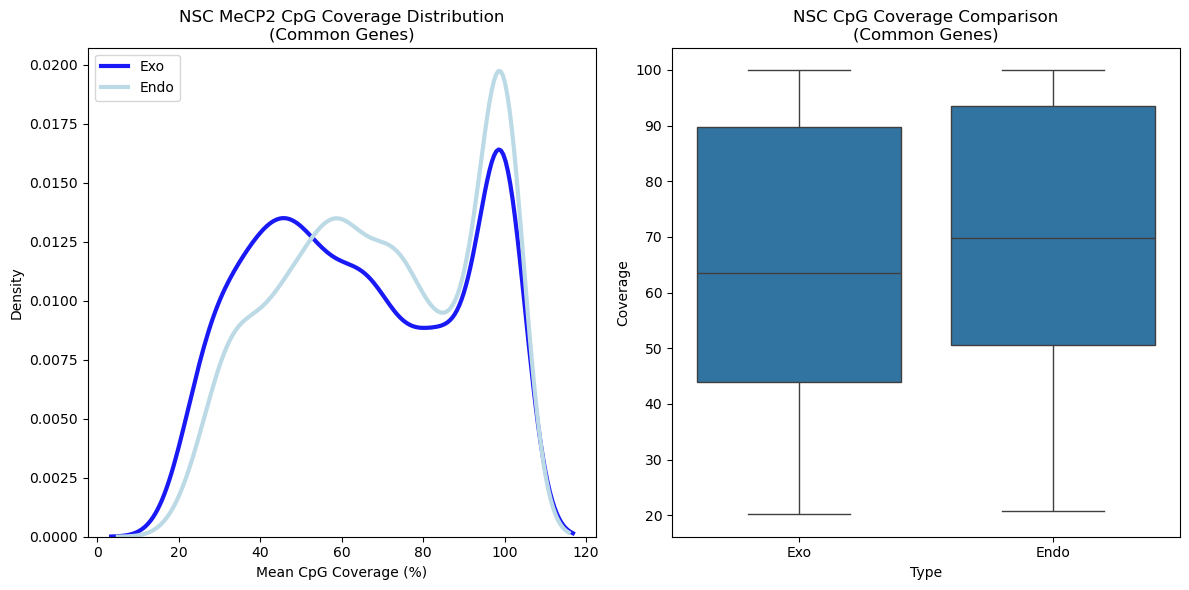


NSC Exo vs Endo Mann-Whitney U test results (Common Genes):
Statistic: 1490904.5
p-value: 5.209272033988007e-08

NSC Summary Statistics (Common Genes):
Exo mean coverage: 65.17%
Endo mean coverage: 69.63%
Exo median coverage: 63.59%
Endo median coverage: 69.74%

Number of common genes in Neurons: 6480


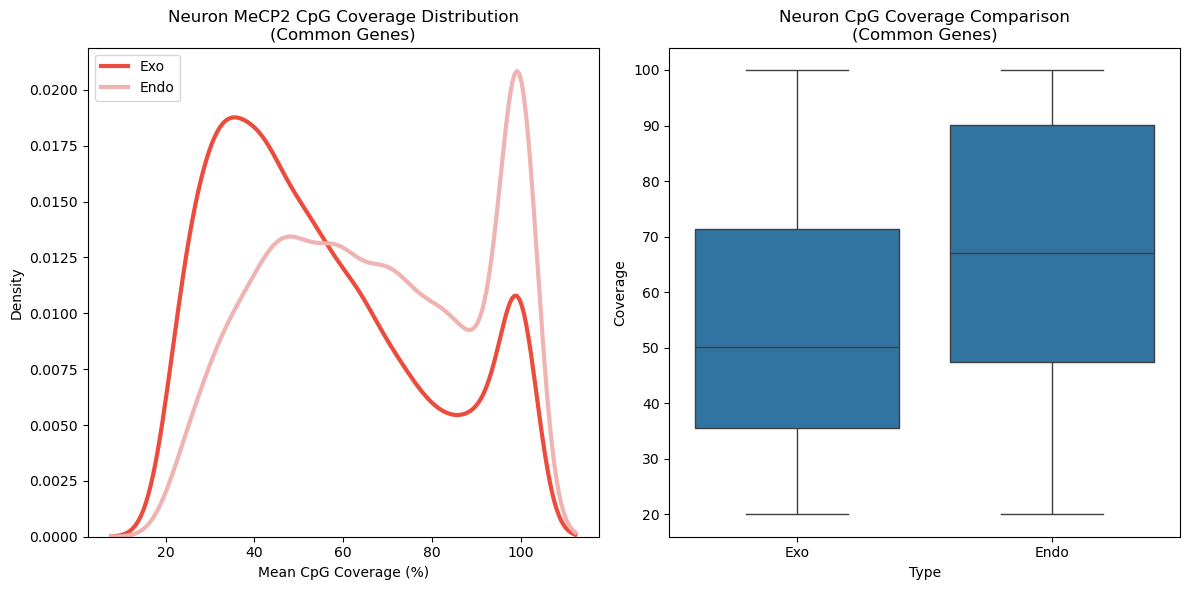


Neuron Exo vs Endo Mann-Whitney U test results (Common Genes):
Statistic: 14748097.0
p-value: 1.6823131114237161e-189

Neuron Summary Statistics (Common Genes):
Exo mean coverage: 55.15%
Endo mean coverage: 67.49%
Exo median coverage: 50.10%
Endo median coverage: 67.01%


In [206]:
compare_exo_endo_coverage_common(data)